# CS 184A Final Project: OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction
Kaggle Competiton Link: https://www.kaggle.com/c/stanford-covid-vaccine/overview.
## Project Members: Junchen Zhao, Shuo Yan.


In [1]:
# Import Relevant Packages
import os
from google.colab import files
from google.colab import drive
import copy
import os
import time
import traceback
from contextlib import contextmanager
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

!pip install nyaggle
from nyaggle.validation import StratifiedGroupKFold
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 1.4MB 14.5MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 266kB 51.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.9MB 50.0MB/s 
     |████████████████████████████████| 890kB 65.2MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 163kB 63.2MB/s 
     |████████████████████████████████| 133kB 62.6MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 112kB 48.1MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=1b29dae19f2895ff13e665f0dbd67b0172f8338a9186752adf7f8ca819b449aa
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/6

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Define GPU and check whether GPU is using 
use_GPU = torch.cuda.is_available()
device = torch.device("cuda" if use_GPU else "cpu")
if use_GPU:
    torch.cuda.manual_seed(0)
print("Using GPU: {}".format(use_GPU))

Using GPU: True


## Part 1: Uploading Data

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.makedirs("stanford-covid-vaccine")
os.makedirs("eternafold")
os.makedirs("bpps-by-viennat70")
!unzip drive/"My Drive"/stanford-covid-vaccine.zip -d "stanford-covid-vaccine"
!unzip drive/"My Drive"/eternafold.zip -d "eternafold"
!unzip drive/"My Drive"/bpps-by-vienaa.zip -d "bpps-by-viennat70"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: bpps-by-viennat70/bpps/id_2a65e9f2b.npy  
  inflating: bpps-by-viennat70/bpps/id_2a66a03f6.npy  
  inflating: bpps-by-viennat70/bpps/id_2a6a9af2b.npy  
  inflating: bpps-by-viennat70/bpps/id_2a7568244.npy  
  inflating: bpps-by-viennat70/bpps/id_2a7a4496f.npy  
  inflating: bpps-by-viennat70/bpps/id_2a983d026.npy  
  inflating: bpps-by-viennat70/bpps/id_2a9950bb9.npy  
  inflating: bpps-by-viennat70/bpps/id_2aa8d42fb.npy  
  inflating: bpps-by-viennat70/bpps/id_2ab513ee0.npy  
  inflating: bpps-by-viennat70/bpps/id_2abce6b09.npy  
  inflating: bpps-by-viennat70/bpps/id_2ac476592.npy  
  inflating: bpps-by-viennat70/bpps/id_2ac864952.npy  
  inflating: bpps-by-viennat70/bpps/id_2acaec4d9.npy  
  inflating: bpps-by-viennat70/bpps/id_2ad904ce7.npy  
  inflating: bpps-by-viennat70/bpps/id_2adc98948.npy  
  inflating: bpps-by-viennat70/bpps/id_2adcc95ee.npy  
  inflating: bpps-by-viennat70/bpps/id_2adf6505a.npy  
  inflating: bpps-by-viennat70/bpps/id

In [5]:
TOKEN2INT = {x: i for i, x in enumerate('().ACGUBEHIMSX')}
PRED_COLS_SCORED = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']
PRED_COLS = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']

DATA_DIR = "/content/stanford-covid-vaccine/"
REPLACE_DATA_PATH = "/content/eternafold/eternafold_mfe.csv"
PRIMARY_BPPS_DIR = "../content/eternafold/bpps/"
SECONDARY_BPPS_DIR = "../content/bpps-by-viennat70/"
NFOLDS = 7
BATCH_SIZE = 64
TRAIN_EPOCHS = 140

## Part 3: Building Training Model Architecture
1. SELayer: Model based on Squeeze-and-Excitation Networks.
2. Conv: Model based on Covolutional Neural Network.
3. ResidualGraphAttention: Model based on Residual Attention Graph Convolutional Network for Geometric 3D Scene Classification.
4. SEResidual: Model based on Residual Squeeze-and-Excitation Network for Fast Image Deraining.
5. FusedEmbedding: Model for extracting the data and transforing the data to integer.

In [6]:
# Build SELayer Achitecture
class SELayer(nn.Module):
  def __init__(self, channel, reduction=16):
    super(SELayer, self).__init__()
    self.avg_pool = nn.AdaptiveAvgPool1d(1)
    self.fc = nn.Sequential(
        nn.Linear(channel, channel // reduction, bias=False),
        nn.ReLU(inplace=True),
        nn.Linear(channel // reduction, channel, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    b, c, _ = x.size()
    y = self.avg_pool(x).view(b, c)
    y = self.fc(y).view(b, c, 1)
    return x * y.expand_as(x)

In [7]:
# Build CNN Network Achitecture
class Conv(nn.Module):
  def __init__(self, d_in, d_out, kernel_size, dropout=0.1):
    super().__init__()
    self.conv = nn.Conv1d(d_in, d_out, kernel_size=kernel_size, padding=kernel_size // 2)
    self.bn = nn.BatchNorm1d(d_out)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

  def forward(self, src):
    return self.dropout(self.relu(self.bn(self.conv(src))))

In [8]:
# Build Residual Graph Attention Achitecture
class ResidualGraphAttention(nn.Module):
  def __init__(self, d_model, kernel_size, dropout):
    super().__init__()
    self.conv1 = Conv(d_model, d_model, kernel_size=kernel_size, dropout=dropout)
    self.conv2 = Conv(d_model, d_model, kernel_size=kernel_size, dropout=dropout)
    self.relu = nn.ReLU()

  def forward(self, src, attn):
    h = self.conv2(self.conv1(torch.bmm(src, attn)))
    return self.relu(src + h)

In [9]:
# Build SEResidual Model Achitecture
class SEResidual(nn.Module):
  def __init__(self, d_model, kernel_size, dropout):
    super().__init__()
    self.conv1 = Conv(d_model, d_model, kernel_size=kernel_size, dropout=dropout)
    self.conv2 = Conv(d_model, d_model, kernel_size=kernel_size, dropout=dropout)
    self.relu = nn.ReLU()
    self.se = SELayer(d_model)

  def forward(self, src):
    h = self.conv2(self.conv1(src))
    return self.se(self.relu(src + h))

In [10]:
# Build Fused Embedding Achitecture
class FusedEmbedding(nn.Module):
  def __init__(self, n_emb):
    super().__init__()
    self.emb = nn.Embedding(len(TOKEN2INT), n_emb)
    self.n_emb = n_emb

  def forward(self, src, se):
    # src: [batch, seq, feature]
    # se: [batch, seq]
    embed = self.emb(src)
    embed = embed.reshape((-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
    embed = torch.cat((embed, se), 2)

    return embed

  @property
  def d_out(self):
    d_emb = 3 * self.n_emb
    d_feat = 2 * 5  # max, sum, 2nd, 3rd, nb_count
    return d_emb + d_feat

In [11]:
# Build Convolutional Neural network for training
class ConvModel(nn.Module):
  def __init__(self, d_emb=50, d_model=256, dropout=0.6, dropout_res=0.4, dropout_emb=0.0, kernel_size_conv=7, kernel_size_gc=7):
    super().__init__()

    self.embedding = FusedEmbedding(d_emb)
    self.dropout = nn.Dropout(dropout_emb)
    self.conv = Conv(self.embedding.d_out, d_model, kernel_size=3, dropout=dropout)

    self.block1 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)
    self.block2 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)
    self.block3 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)
    self.block4 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)
    self.block5 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)

    self.attn1 = ResidualGraphAttention(d_model, kernel_size=kernel_size_gc, dropout=dropout_res)
    self.attn2 = ResidualGraphAttention(d_model, kernel_size=kernel_size_gc, dropout=dropout_res)
    self.attn3 = ResidualGraphAttention(d_model, kernel_size=kernel_size_gc, dropout=dropout_res)
    self.attn4 = ResidualGraphAttention(d_model, kernel_size=kernel_size_gc, dropout=dropout_res)

    self.linear = nn.Linear(d_model, len(PRED_COLS))

  def forward(self, src: torch.Tensor, features: torch.Tensor, bpps: torch.Tensor, adj: torch.Tensor):
    # src: [batch, seq, 3]
    # features: [batch, seq, 10]
    # bpps: [batch, seq, seq, 2]
    # adj: [batch, seq, seq]
    
    x = self.dropout(self.embedding(src, features))
    x = x.permute([0, 2, 1])  # [batch, d-emb, seq]
    
    x = self.conv(x)
    x = self.block1(x)
    x = self.attn1(x, adj)
    x = self.block2(x)
    x = self.attn2(x, adj)
    x = self.block3(x)
    x = self.attn3(x, bpps[:, :, :, 0])
    x = self.attn4(x, bpps[:, :, :, 1])
    x = self.block4(x)
    x = self.block5(x)

    x = x.permute([0, 2, 1])  # [batch, seq, features]
    out = self.linear(x)

    out = torch.clamp(out, -0.5, 1e8)

    return out
    

## Build Loss Function Architecture:
Initial Intuition is based on the work of: https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183211.
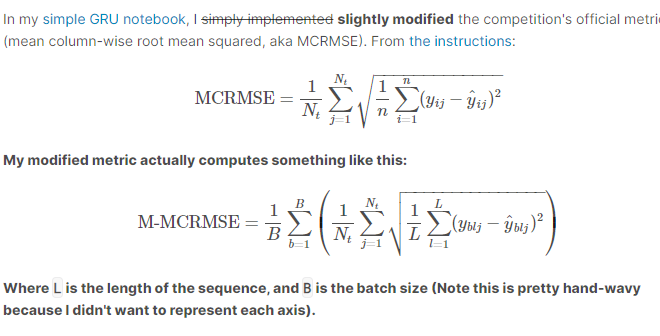

In [12]:
# Build WRMSELoss Architecture
class WRMSELoss(nn.Module): #weighted RMSE Loss
  def __init__(self):
    super().__init__()

  def forward(self, yhat, y, sample_weight=None):
    l = (yhat - y) ** 2

    if sample_weight is not None:
      l = l * sample_weight.unsqueeze(dim=1)

    return torch.sqrt(torch.mean(l))

In [13]:
# Build ColWiseLoss Architecture
class ColWiseLoss(nn.Module): #Column wised loss calculation
  def __init__(self, base_loss):
    super().__init__()
    self.base_loss = base_loss
    self.len_scored = 68

  def forward(self, yhat, y, column_weight=None, sample_weight=None):
    score = 0
    for i in range(len(PRED_COLS)):
      s = self.base_loss(
          yhat[:, :self.len_scored, i], 
          y[:, :self.len_scored, i], 
          sample_weight
      ) / len(PRED_COLS)
      
      if column_weight is not None:
          s *= column_weight[i]
          
      score += s
    return score

In [14]:
# Build MCRMSELoss Architecture
class MCRMSELoss(ColWiseLoss): #simple custom loss (single model, no noise filtering, no LSTM)
  # This loss function is the WRMSE fused with the Column-wised loss function
  def __init__(self):
    super().__init__(WRMSELoss())

## Part 5: Defining Utility Function

In [15]:
def pandas_list_to_array(df: pd.DataFrame) -> np.ndarray:
  return np.transpose( np.array( df.values.tolist()), (0, 2, 1))

def preprocess_inputs(df: pd.DataFrame) -> np.ndarray:
  return pandas_list_to_array(
      df[['sequence', 'structure', 'predicted_loop_type']].applymap(lambda seq: [TOKEN2INT[x] for x in seq]))


def build_adj_matrix(src_df: pd.DataFrame, normalize: bool = True) -> np.ndarray:
  n = len(src_df['structure'].iloc[0])
  mat = np.zeros((len(src_df), n, n))
  start_token_indices = []

  for r, structure in tqdm(enumerate(src_df['structure'])):
    for i, token in enumerate(structure):
      if token == "(":
        start_token_indices.append(i)
      elif token == ")":
        j = start_token_indices.pop()
        mat[r, i, j] = 1
        mat[r, j, i] = 1

  assert len(start_token_indices) == 0

  if normalize:
    mat = mat / (mat.sum(axis=2, keepdims=True) + 1e-8)

  return mat

In [16]:
def replace_data(train_df: pd.DataFrame, test_df: pd.DataFrame, replace_data_dir: str):
  print(f"using data from {replace_data_dir}")

  aux = pd.read_csv(replace_data_dir)
  del train_df['structure']
  del train_df['predicted_loop_type']
  del test_df['structure']
  del test_df['predicted_loop_type']
  train_df = pd.merge(train_df, aux, on='id', how='left')
  test_df = pd.merge(test_df, aux, on='id', how='left')
  assert len(train_df) == 2400
  assert len(test_df) == 3634
  assert train_df['structure'].isnull().sum() == 0
  assert train_df['predicted_loop_type'].isnull().sum() == 0
  assert test_df['structure'].isnull().sum() == 0
  assert test_df['predicted_loop_type'].isnull().sum() == 0
  return train_df, test_df

In [17]:
def load_bpps(df: pd.DataFrame, data_dir: str) -> np.ndarray:
  return np.array([np.load(f'{data_dir}bpps/{did}.npy') for did in df.id])

In [18]:
def make_bpps_features(bpps_list: List[np.ndarray]) -> np.ndarray:
  ar = []

  for b in bpps_list:
    ar.append(b.sum(axis=2))

    # max, 2ndmax, 3rdmax
    bpps_sorted = np.sort(b, axis=2)[:, :, ::-1]
    ar.append(bpps_sorted[:, :, 0])
    ar.append(bpps_sorted[:, :, 1])
    ar.append(bpps_sorted[:, :, 2])

    # number of nonzero
    bpps_nb_mean = 0.077522  # mean of bpps_nb across all training data
    bpps_nb_std = 0.08914  # std of bpps_nb across all training data
    nb = (b > 0).sum(axis=2)
    nb = (nb - bpps_nb_mean) / bpps_nb_std
    ar.append(nb)

  return np.transpose(np.array(ar), (1, 2, 0))

In [19]:
def make_dataset(device, x: np.ndarray, y: np.ndarray,
                 bpps_primary: np.ndarray,
                 bpps_secondary: np.ndarray,
                 adj_matrix: np.ndarray,
                 prediction_mask: np.ndarray,
                 signal_to_noise=None):
  x = copy.deepcopy(x)
  if y is not None:
      y = copy.deepcopy(y)
  bpps_primary = copy.deepcopy(bpps_primary)
  bpps_secondary = copy.deepcopy(bpps_secondary)
  bpps = np.concatenate([
      bpps_primary[:, :, :, np.newaxis],
      bpps_secondary[:, :, :, np.newaxis]
  ], axis=-1)

  adj_matrix = copy.deepcopy(adj_matrix)
  prediction_mask = copy.deepcopy(prediction_mask)

  if y is not None:
      y = np.clip(y, -0.5, 10)
      mask = np.abs(y).max(axis=(1, 2)) < 10
  else:
      mask = [True] * len(x)

  tensors = [
      torch.LongTensor(x[mask]),
      torch.Tensor(make_bpps_features([bpps_primary[mask], bpps_secondary[mask]])),
      torch.Tensor(bpps[mask]),
      torch.Tensor(adj_matrix[mask]),
      torch.Tensor(prediction_mask[mask])
  ]

  if y is not None:
      tensors.append(torch.Tensor(y[mask]))
      
      sample_weight = np.clip(np.log(signal_to_noise[mask] + 1.1) / 2, 0, 100)
      tensors.append(torch.Tensor(sample_weight))

  return torch.utils.data.TensorDataset(*[t.to(device) for t in tensors])

In [20]:
def make_dataset_from_df(device, df: pd.DataFrame, bpps_dir: str, secondary_bpps_dir: str):
  assert df['seq_scored'].nunique() == 1

  inputs = preprocess_inputs(df)
  bpps = load_bpps(df, bpps_dir)
  adj = build_adj_matrix(df)
  secondary_bpps = load_bpps(df, secondary_bpps_dir)

  mask = np.zeros((len(df), len(df['sequence'].iloc[0]), len(PRED_COLS)))
  mask[:, :df['seq_scored'].iloc[0], :] = 1

  return make_dataset(device, inputs, None, bpps, secondary_bpps, adj, mask)

In [21]:
def dist(s1: str, s2: str) -> int:
  return sum([c1 != c2 for c1, c2 in zip(s1, s2)])


def get_distance_matrix(s: pd.Series) -> np.ndarray:
  mat = np.zeros((len(s), len(s)))

  for i in tqdm(range(len(s))):
      for j in range(i + 1, len(s)):
          mat[i, j] = mat[j, i] = dist(s[i], s[j])
  return mat

In [22]:
def batch_predict(model: nn.Module, loader: DataLoader) -> np.ndarray:
  y_preds = np.zeros((len(loader.dataset), loader.dataset[0][0].shape[0], len(PRED_COLS)))

  for i, (x_batch, x_se, x_bpps, x_adj, y_mask) in enumerate(loader):
      y_pred = model(x_batch, x_se, x_bpps, x_adj).detach() * y_mask
      y_preds[i * loader.batch_size:(i + 1) * loader.batch_size, :, :] = y_pred.cpu().numpy()
      
  return y_preds

In [23]:
def calc_loss(y_true: np.ndarray, y_pred: np.ndarray):
  err_w_valid = [1 if s in PRED_COLS_SCORED else 0 for s in PRED_COLS]
  raw = MCRMSELoss()(torch.Tensor(y_pred), torch.Tensor(y_true), err_w_valid).item()
  
  return raw * len(PRED_COLS) / len(PRED_COLS_SCORED)

## Part 6: Defining Model Training function

In [24]:
def train_model(model, train_loader, valid_loader, y_valid,
                train_epochs, train_loss, verbose=True,
                model_path='model'):
  params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  print(f'number of params: {params}')

  err_w_train_1 = [1 if s in PRED_COLS_SCORED else 1.0 for s in PRED_COLS]
  err_w_train_2 = [1 if s in PRED_COLS_SCORED else 0.01 for s in PRED_COLS]

  criterion_train = train_loss
  optimizer = torch.optim.Adam(model.parameters())

  losses = []
  val_losses = []
  y_preds_best = None

  for epoch in range(train_epochs):
    start_time = time.time()

    model.train()
    avg_loss = 0.

    for x_batch, x_se, x_bpps, x_adj, y_mask, y_batch, sample_weight in tqdm(train_loader, disable=True):
      y_pred = model(x_batch, x_se, x_bpps, x_adj) * y_mask
      
      # use 5 columns for the first 30 epoch
      w = err_w_train_1 if epoch < 30 else err_w_train_2
      
      loss = criterion_train(y_pred, y_batch, w, sample_weight)
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      avg_loss += loss.item() / len(train_loader)

    model.eval()
    y_preds = batch_predict(model, valid_loader)
    mcloss = calc_loss(y_valid, y_preds)
    val_losses.append(mcloss)
    
    s = f"{epoch:03d}: trn:{avg_loss:.4f}, clean={mcloss:.4f}, {time.time() - start_time:.2f}s"

    losses.append(avg_loss)

    if np.min(val_losses) == mcloss:
        y_preds_best = y_preds
        torch.save(model.state_dict(), model_path)

    if (isinstance(verbose, bool) and verbose) or (verbose > 0 and (epoch % verbose == 0)):
        print(s)

  print(f'min val_loss: {np.min(val_losses):.4f} at {np.argmin(val_losses) + 1} epoch')

  # recover best weight
  model.load_state_dict(torch.load(model_path))

  if not verbose:
    return np.min(val_losses)

  fig, ax = plt.subplots(1, 3, figsize=(24, 8))

  ax[0].plot(np.arange(1, len(losses) + 1), losses)
  ax[1].plot(np.arange(1, len(val_losses) + 1), val_losses)

  for i, p in enumerate(PRED_COLS):
    ax[2].scatter(y_valid[:, :, i].flatten(), y_preds_best[:, :, i].flatten(), alpha=0.5)

  ax[0].legend(['train'])
  ax[1].legend(['valid(clean)'])
  ax[2].legend(PRED_COLS)
  ax[2].set_xlabel('y_true')
  ax[2].set_ylabel('y_predicted')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('loss')
  ax[2].set_xlabel('y_true(clean)')
  ax[2].set_ylabel('y_predicted(clean)')
  plt.show()

  return np.min(val_losses)

## Part 7: Loading Training and Testing Data

In [25]:
train_df = pd.read_json(DATA_DIR + 'train.json', lines=True)
test_df = pd.read_json(DATA_DIR + 'test.json', lines=True)
sample_df = pd.read_csv(DATA_DIR + 'sample_submission.csv')

train_df, test_df = replace_data(train_df, test_df, REPLACE_DATA_PATH)


# use clustering based on edit distance
seq_dist = get_distance_matrix(train_df['sequence'])
clf = AgglomerativeClustering(n_clusters=None, distance_threshold=20, affinity='precomputed', linkage='average')
group_index = clf.fit_predict(seq_dist)

  0%|          | 0/2400 [00:00<?, ?it/s]

using data from /content/eternafold/eternafold_mfe.csv


100%|██████████| 2400/2400 [00:53<00:00, 44.57it/s] 


In [26]:
public_df = test_df.query("seq_length != 130")
private_df = test_df.query("seq_length == 130")

x = preprocess_inputs(train_df)
y = pandas_list_to_array(train_df[PRED_COLS])

label_mask = np.ones_like(y)
pad = np.zeros((y.shape[0], x.shape[1] - y.shape[1], y.shape[2]))
y = np.concatenate((y, pad), axis=1)
label_mask = np.concatenate((label_mask, pad), axis=1)

assert x.shape[1] == y.shape[1]

train_adj = build_adj_matrix(train_df)
primary_bpps = load_bpps(train_df, PRIMARY_BPPS_DIR)    
secondary_bpps = load_bpps(train_df, SECONDARY_BPPS_DIR)

public_data = make_dataset_from_df(device, public_df, PRIMARY_BPPS_DIR, SECONDARY_BPPS_DIR)
private_data = make_dataset_from_df(device, private_df, PRIMARY_BPPS_DIR, SECONDARY_BPPS_DIR)

2400it [00:00, 42202.23it/s]
629it [00:00, 45730.93it/s]
3005it [00:00, 32541.10it/s]


## Part 8: Training our CNN+GCN model

fold 0
number of params: 8437953
000: trn:0.3892, clean=0.4903, 2.13s
005: trn:0.2683, clean=0.2760, 1.83s
010: trn:0.2439, clean=0.2560, 1.82s
015: trn:0.2278, clean=0.2420, 1.83s
020: trn:0.2208, clean=0.2398, 1.85s
025: trn:0.2126, clean=0.2402, 1.82s
030: trn:0.1210, clean=0.2388, 1.83s
035: trn:0.1163, clean=0.2311, 1.85s
040: trn:0.1145, clean=0.2333, 1.83s
045: trn:0.1106, clean=0.2265, 1.82s
050: trn:0.1091, clean=0.2266, 1.81s
055: trn:0.1068, clean=0.2294, 1.83s
060: trn:0.1049, clean=0.2308, 1.82s
065: trn:0.1038, clean=0.2284, 1.83s
070: trn:0.1026, clean=0.2308, 1.83s
075: trn:0.1016, clean=0.2319, 1.82s
080: trn:0.0998, clean=0.2305, 1.82s
085: trn:0.0989, clean=0.2274, 1.84s
090: trn:0.0971, clean=0.2287, 1.82s
095: trn:0.0963, clean=0.2297, 1.82s
100: trn:0.0952, clean=0.2307, 1.85s
105: trn:0.0943, clean=0.2286, 1.83s
110: trn:0.0935, clean=0.2265, 1.86s
115: trn:0.0933, clean=0.2299, 1.85s
120: trn:0.0918, clean=0.2287, 1.82s
125: trn:0.0906, clean=0.2297, 1.83s
130: 

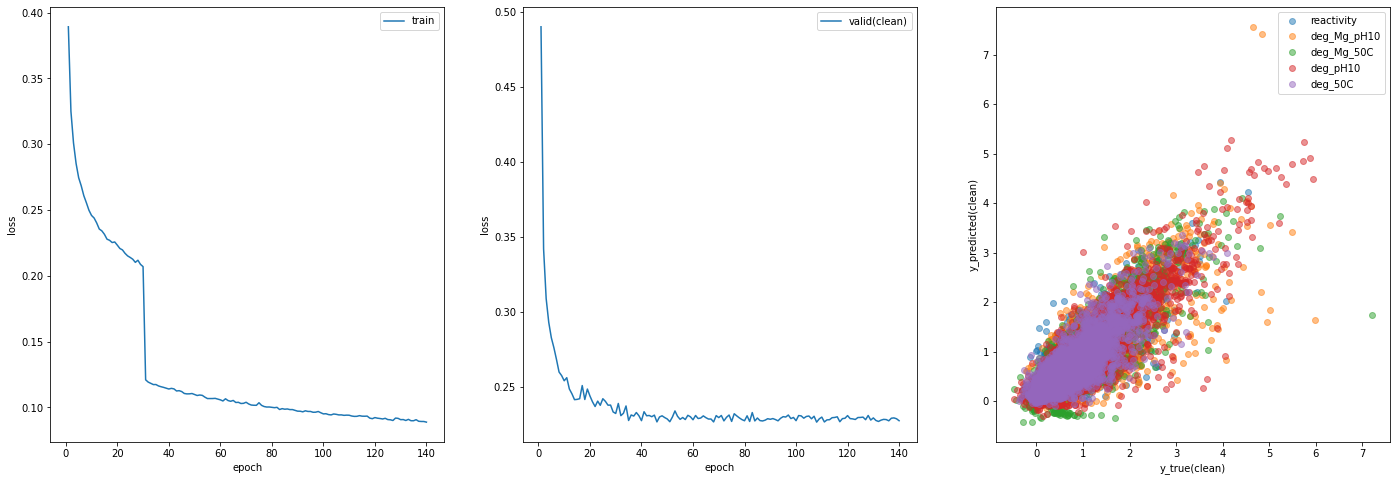

elapsed: 262.6sec
fold 1
number of params: 8437953
000: trn:0.3837, clean=0.3616, 1.85s
005: trn:0.2603, clean=0.2756, 1.85s
010: trn:0.2389, clean=0.2534, 1.82s
015: trn:0.2291, clean=0.2463, 1.83s
020: trn:0.2170, clean=0.2420, 1.83s
025: trn:0.2101, clean=0.2372, 1.83s
030: trn:0.1210, clean=0.2337, 1.84s
035: trn:0.1158, clean=0.2316, 1.83s
040: trn:0.1155, clean=0.2307, 1.83s
045: trn:0.1111, clean=0.2264, 1.84s
050: trn:0.1086, clean=0.2286, 1.83s
055: trn:0.1070, clean=0.2257, 1.86s
060: trn:0.1050, clean=0.2276, 1.82s
065: trn:0.1038, clean=0.2250, 1.84s
070: trn:0.1021, clean=0.2222, 1.85s
075: trn:0.1004, clean=0.2208, 1.85s
080: trn:0.0997, clean=0.2217, 1.83s
085: trn:0.0977, clean=0.2214, 1.84s
090: trn:0.0971, clean=0.2216, 1.83s
095: trn:0.0967, clean=0.2198, 1.85s
100: trn:0.0960, clean=0.2219, 1.83s
105: trn:0.0939, clean=0.2214, 1.85s
110: trn:0.0926, clean=0.2215, 1.83s
115: trn:0.0921, clean=0.2204, 1.83s
120: trn:0.0917, clean=0.2224, 1.84s
125: trn:0.0909, clean=0

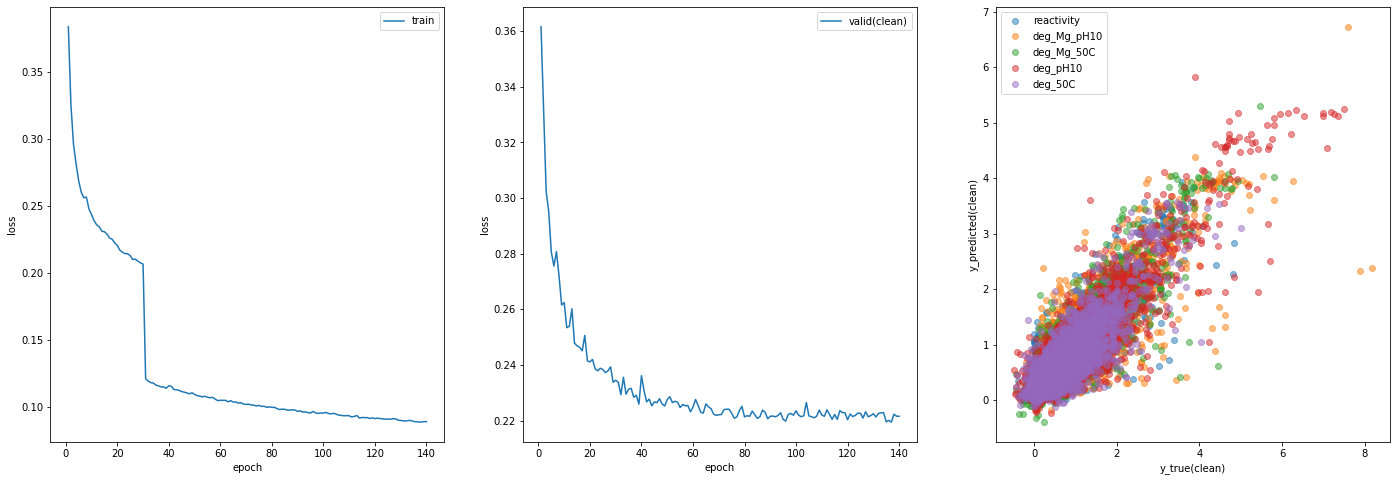

elapsed: 265.1sec
fold 2
number of params: 8437953
000: trn:0.3989, clean=0.5764, 1.86s
005: trn:0.2783, clean=0.2926, 1.85s
010: trn:0.2455, clean=0.2634, 1.86s
015: trn:0.2316, clean=0.2526, 1.85s
020: trn:0.2203, clean=0.2449, 1.87s
025: trn:0.2125, clean=0.2424, 1.87s
030: trn:0.1213, clean=0.2384, 1.85s
035: trn:0.1168, clean=0.2391, 1.86s
040: trn:0.1140, clean=0.2315, 1.86s
045: trn:0.1114, clean=0.2324, 1.85s
050: trn:0.1096, clean=0.2375, 1.88s
055: trn:0.1083, clean=0.2314, 1.88s
060: trn:0.1054, clean=0.2335, 1.86s
065: trn:0.1042, clean=0.2307, 1.84s
070: trn:0.1019, clean=0.2297, 1.85s
075: trn:0.1003, clean=0.2266, 1.86s
080: trn:0.0996, clean=0.2305, 1.85s
085: trn:0.0982, clean=0.2319, 1.86s
090: trn:0.0978, clean=0.2328, 1.87s
095: trn:0.0956, clean=0.2297, 1.86s
100: trn:0.0948, clean=0.2317, 1.86s
105: trn:0.0937, clean=0.2293, 1.87s
110: trn:0.0931, clean=0.2331, 1.83s
115: trn:0.0923, clean=0.2337, 1.84s
120: trn:0.0917, clean=0.2272, 1.85s
125: trn:0.0902, clean=0

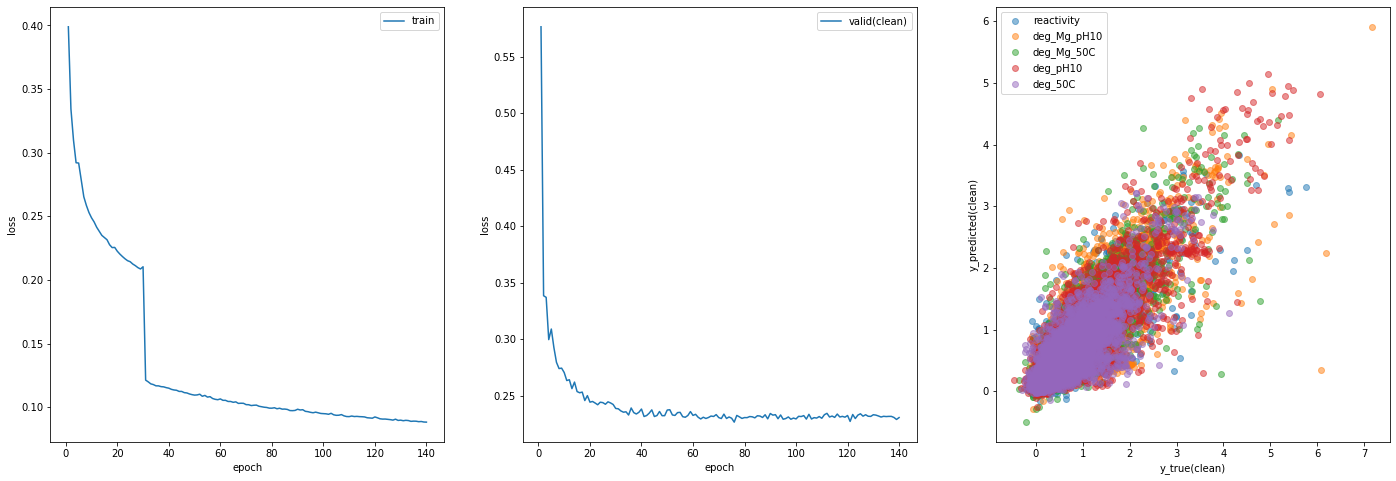

elapsed: 266.2sec
fold 3
number of params: 8437953
000: trn:0.3875, clean=0.3779, 1.84s
005: trn:0.2639, clean=0.2935, 1.82s
010: trn:0.2397, clean=0.2680, 1.84s
015: trn:0.2272, clean=0.2615, 1.83s
020: trn:0.2182, clean=0.2563, 1.84s
025: trn:0.2102, clean=0.2525, 1.84s
030: trn:0.1200, clean=0.2492, 1.84s
035: trn:0.1157, clean=0.2487, 1.83s
040: trn:0.1135, clean=0.2474, 1.83s
045: trn:0.1106, clean=0.2461, 1.83s
050: trn:0.1088, clean=0.2468, 1.82s
055: trn:0.1065, clean=0.2482, 1.83s
060: trn:0.1046, clean=0.2451, 1.85s
065: trn:0.1034, clean=0.2448, 1.85s
070: trn:0.1027, clean=0.2447, 1.83s
075: trn:0.1007, clean=0.2416, 1.83s
080: trn:0.0985, clean=0.2407, 1.83s
085: trn:0.0978, clean=0.2474, 1.83s
090: trn:0.0972, clean=0.2433, 1.85s
095: trn:0.0956, clean=0.2419, 1.83s
100: trn:0.0949, clean=0.2451, 1.82s
105: trn:0.0938, clean=0.2441, 1.82s
110: trn:0.0925, clean=0.2420, 1.83s
115: trn:0.0924, clean=0.2416, 1.83s
120: trn:0.0916, clean=0.2404, 1.82s
125: trn:0.0909, clean=0

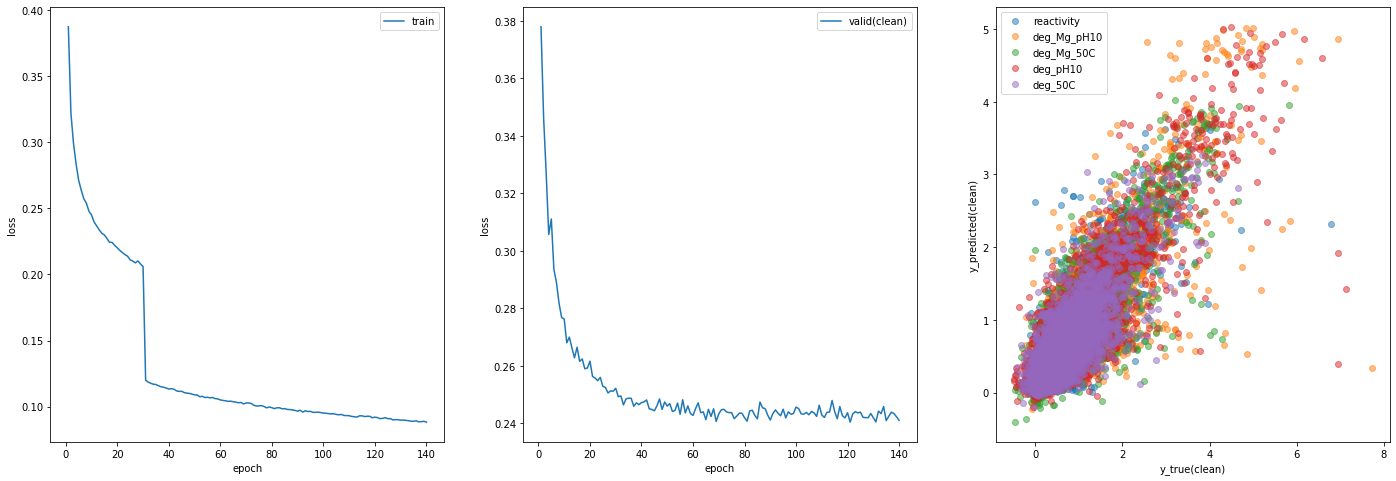

elapsed: 263.8sec
fold 4
number of params: 8437953
000: trn:0.3931, clean=0.3684, 1.88s
005: trn:0.2651, clean=0.2664, 1.85s
010: trn:0.2413, clean=0.2494, 1.91s
015: trn:0.2272, clean=0.2389, 1.85s
020: trn:0.2198, clean=0.2354, 1.84s
025: trn:0.2113, clean=0.2362, 1.85s
030: trn:0.1217, clean=0.2313, 1.85s
035: trn:0.1162, clean=0.2286, 1.83s
040: trn:0.1139, clean=0.2269, 1.85s
045: trn:0.1115, clean=0.2283, 1.86s
050: trn:0.1106, clean=0.2258, 1.83s
055: trn:0.1077, clean=0.2267, 1.85s
060: trn:0.1060, clean=0.2276, 1.85s
065: trn:0.1035, clean=0.2267, 1.83s
070: trn:0.1017, clean=0.2251, 1.84s
075: trn:0.1008, clean=0.2248, 1.84s
080: trn:0.1003, clean=0.2257, 1.84s
085: trn:0.0993, clean=0.2225, 1.83s
090: trn:0.0974, clean=0.2266, 1.83s
095: trn:0.0961, clean=0.2252, 1.80s
100: trn:0.0956, clean=0.2287, 1.83s
105: trn:0.0944, clean=0.2255, 1.84s
110: trn:0.0940, clean=0.2233, 1.84s
115: trn:0.0928, clean=0.2334, 1.84s
120: trn:0.0923, clean=0.2280, 1.84s
125: trn:0.0902, clean=0

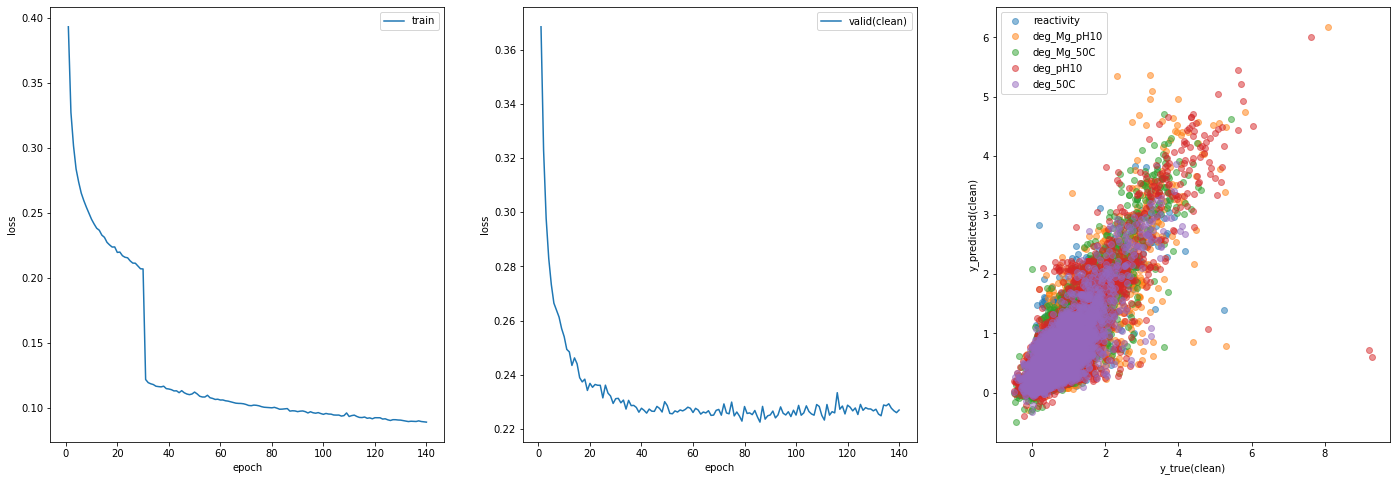

elapsed: 264.8sec
fold 5
number of params: 8437953
000: trn:0.3907, clean=0.8331, 1.85s
005: trn:0.2681, clean=0.2839, 1.83s
010: trn:0.2429, clean=0.2612, 1.84s
015: trn:0.2284, clean=0.2541, 1.82s
020: trn:0.2184, clean=0.2522, 1.84s
025: trn:0.2118, clean=0.2421, 1.81s
030: trn:0.1209, clean=0.2372, 1.82s
035: trn:0.1153, clean=0.2363, 1.82s
040: trn:0.1125, clean=0.2385, 1.83s
045: trn:0.1108, clean=0.2373, 1.84s
050: trn:0.1078, clean=0.2361, 1.83s
055: trn:0.1065, clean=0.2357, 1.83s
060: trn:0.1040, clean=0.2334, 1.84s
065: trn:0.1015, clean=0.2322, 1.84s
070: trn:0.1005, clean=0.2336, 1.84s
075: trn:0.0999, clean=0.2361, 1.82s
080: trn:0.0983, clean=0.2334, 1.83s
085: trn:0.0973, clean=0.2335, 1.82s
090: trn:0.0963, clean=0.2342, 1.81s
095: trn:0.0947, clean=0.2302, 1.81s
100: trn:0.0937, clean=0.2331, 1.82s
105: trn:0.0937, clean=0.2317, 1.82s
110: trn:0.0925, clean=0.2332, 1.81s
115: trn:0.0916, clean=0.2339, 1.81s
120: trn:0.0901, clean=0.2321, 1.82s
125: trn:0.0899, clean=0

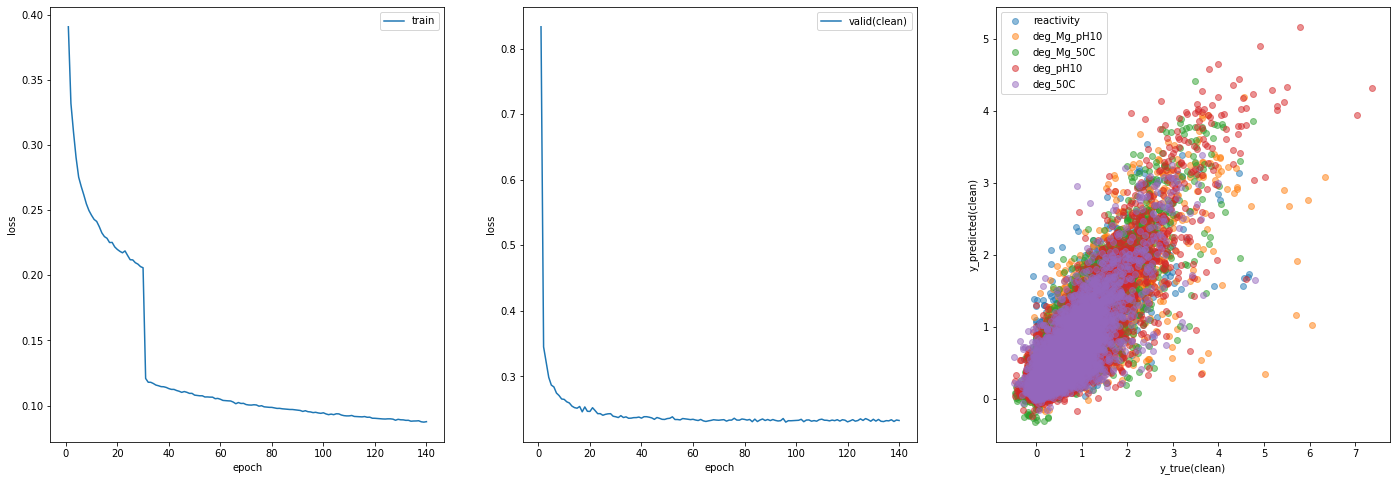

elapsed: 262.5sec
fold 6
number of params: 8437953
000: trn:0.3886, clean=0.3561, 1.83s
005: trn:0.2636, clean=0.2694, 1.81s
010: trn:0.2405, clean=0.2505, 1.84s
015: trn:0.2267, clean=0.2385, 1.83s
020: trn:0.2176, clean=0.2345, 1.81s
025: trn:0.2105, clean=0.2373, 1.82s
030: trn:0.1210, clean=0.2338, 1.84s
035: trn:0.1156, clean=0.2293, 1.83s
040: trn:0.1138, clean=0.2313, 1.84s
045: trn:0.1108, clean=0.2324, 1.82s
050: trn:0.1087, clean=0.2288, 1.82s
055: trn:0.1071, clean=0.2268, 1.81s
060: trn:0.1048, clean=0.2319, 1.82s
065: trn:0.1037, clean=0.2296, 1.81s
070: trn:0.1025, clean=0.2299, 1.83s
075: trn:0.1009, clean=0.2309, 1.84s
080: trn:0.0993, clean=0.2306, 1.83s
085: trn:0.0981, clean=0.2276, 1.83s
090: trn:0.0968, clean=0.2309, 1.84s
095: trn:0.0962, clean=0.2317, 1.84s
100: trn:0.0956, clean=0.2316, 1.80s
105: trn:0.0939, clean=0.2326, 1.83s
110: trn:0.0935, clean=0.2281, 1.83s
115: trn:0.0931, clean=0.2312, 1.82s
120: trn:0.0918, clean=0.2292, 1.84s
125: trn:0.0906, clean=0

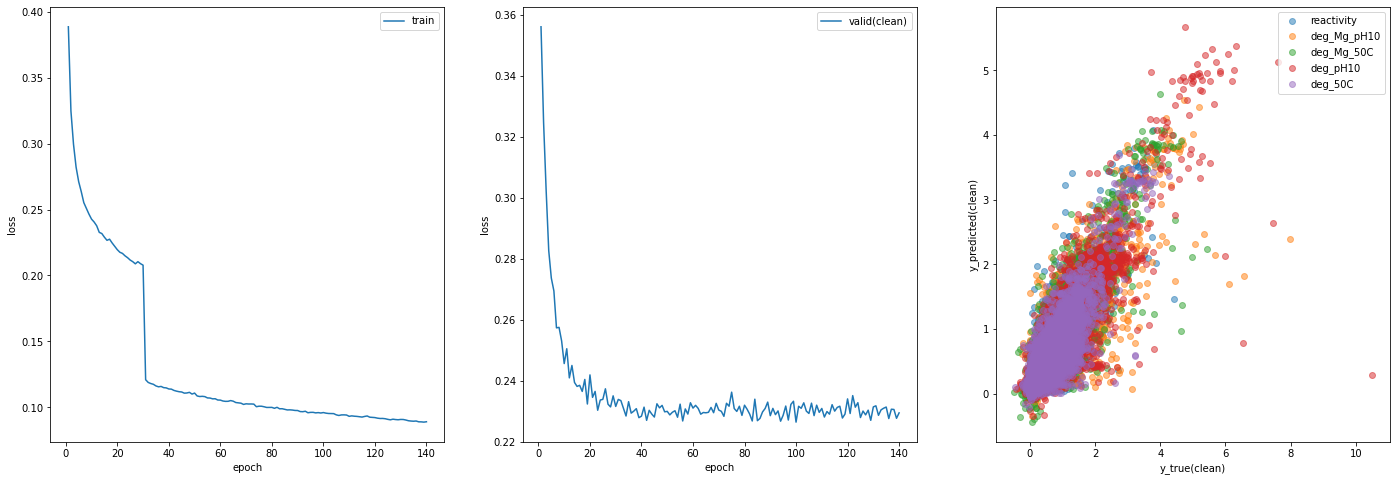

elapsed: 262.0sec
oof(all):  0.6469
oof(clean):  0.2275
[0.22633038461208344, 0.21942853927612305, 0.22656773527463278, 0.2403909961382548, 0.22253225247065225, 0.23024226228396097, 0.2263962229092916]


In [27]:
kf = StratifiedGroupKFold(NFOLDS, random_state=42, shuffle=True)

pred_oof = np.zeros_like(y)
pred_public = np.zeros((len(public_data), len(public_df['sequence'].iloc[0]), len(PRED_COLS)))
pred_private = np.zeros((len(private_data), len(private_df['sequence'].iloc[0]), len(PRED_COLS)))

public_loader = DataLoader(public_data, batch_size=128, shuffle=False)
private_loader = DataLoader(private_data, batch_size=128, shuffle=False)

clean_idx = [i for i in range(len(train_df)) if train_df['SN_filter'].iloc[i]]
sn_mask = train_df['SN_filter'] == 1

criterion_train = MCRMSELoss()
model_path = "model_fold{}"

losses = []

for i, (train_index, valid_index) in enumerate(kf.split(x, train_df['SN_filter'], groups=group_index)):
  print(f'fold {i}')
  model = ConvModel().to(device)
  s = time.time()

  train_data = make_dataset(device, x[train_index], y[train_index],
                            primary_bpps[train_index], secondary_bpps[train_index],
                            train_adj[train_index],
                            label_mask[train_index],
                            signal_to_noise=train_df['signal_to_noise'][train_index].values)

  valid_index_c = [v for v in valid_index if v in clean_idx]
  valid_data_clean = make_dataset(device, x[valid_index_c], None,
                                  primary_bpps[valid_index_c],
                                  secondary_bpps[valid_index_c],
                                  train_adj[valid_index_c],
                                  label_mask[valid_index_c])
  valid_data_noisy = make_dataset(device, x[valid_index], None,
                                primary_bpps[valid_index],
                                secondary_bpps[valid_index],
                                train_adj[valid_index],
                                label_mask[valid_index])

  train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
  valid_loader_clean = DataLoader(valid_data_clean, batch_size=128, shuffle=False)
  valid_loader_noisy = DataLoader(valid_data_noisy, batch_size=128, shuffle=False)

  loss = train_model(model, 
                      train_loader, 
                      valid_loader_clean, 
                      y[valid_index_c], 
                      TRAIN_EPOCHS, 
                      criterion_train,
                      verbose=5, 
                      model_path=model_path.format(i))

  losses.append(loss)

  # predict
  pred_oof[valid_index] = batch_predict(model, valid_loader_noisy)
  pred_public += batch_predict(model, public_loader) / NFOLDS
  pred_private += batch_predict(model, private_loader) / NFOLDS

  print(f'elapsed: {time.time() - s:.1f}sec')

oof_score = calc_loss(y, pred_oof)
print(f'oof(all): {oof_score: .4f}')

oof_score = calc_loss(y[sn_mask], pred_oof[sn_mask])
print(f'oof(clean): {oof_score: .4f}')

print(losses)